# Imports

In [1]:
import cv2 as cv
import shutil
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import time

# Load Image

In [29]:
def plot(img, title=None):
    plt.imshow(img, cmap='gray')
    # plt.rcParams['figure.figsize'] = [2, 2]
    plt.title(title)
    plt.show()

In [3]:
img1 = cv.imread('HSV Model 1.png')
img2 = cv.imread('HSV Model 2.png')
img3 = cv.imread('HSV Model 3.jpg')
img4 = cv.imread('HSV.tiff')

resized_img1 = cv.resize(img1, (500, 500))
resized_img2 = cv.resize(img2, (500, 500))
resized_img3 = cv.resize(img3, (500, 500))

img = np.hstack((resized_img1, resized_img2, resized_img3))

yellow_test = cv.imread('yellow_test.png')
test_rgb = cv.cvtColor(yellow_test, cv.COLOR_BGR2RGB)

rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [4]:
mypath = 'train'

classes = [str(i).zfill(3) for i in range(0, 60)]

files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if f.endswith('.png')]

for i in range(len(files)):
    if files[i][:3] in classes:
        
        # create a folder for each class
        folderName = files[i][:3]
        if folderName == '000': folderName = mypath + '/' + '0'
        else: folderName = mypath + '/' + folderName.lstrip('0')
        if not os.path.exists(folderName): os.mkdir(folderName)
        
        # move the file to the corresponding folder
        shutil.move(mypath + '/' + files[i], folderName + '/' + files[i])


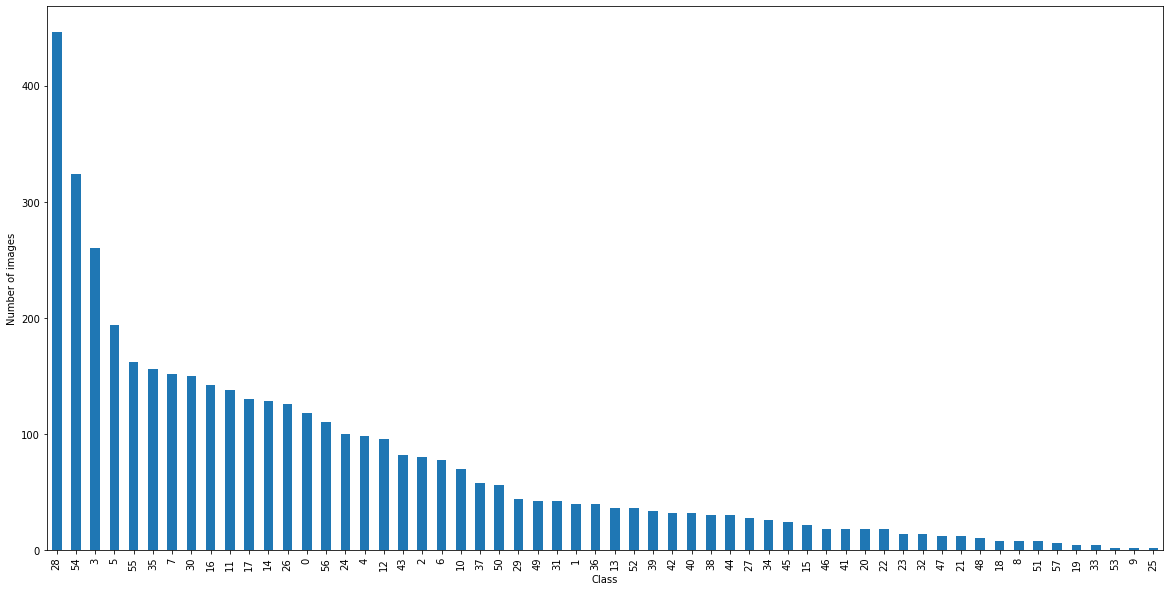

In [31]:
# remove .DS_Store file
if os.path.exists(mypath + '/.DS_Store'): os.remove(mypath + '/.DS_Store')

# convert text file to csv file
textFile = 'TsignRecgTrain4170Annotation.txt'
csvFile = 'TSDR_Labels.csv'

header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
data = pd.read_csv(textFile, sep=';', header=None, index_col=False, names=header)
data.to_csv(csvFile, index=False)

# plot a table of the number of images per class
data['class'].value_counts().plot(kind='bar')
# size of the plot
plt.rcParams['figure.figsize'] = [20, 10]
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

In [6]:
images = []
for i in range(len(data)):
    images.append(cv.imread('tsrd-train/' + data.iloc[i]['filename']))

# Randomly Choose an image

In [32]:
def random_img(idx=None):
    # randomly select an image
    idx = np.random.randint(0, len(data)-1) if idx is None else idx
    img = images[idx]
    return idx, img

idx, img = random_img()

# Pre-process

## HSV color range threshold

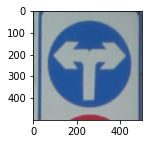

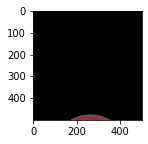

In [35]:
def red_mask(hsv):
    low_lower_red = np.array([0, 80, 0])
    low_upper_red = np.array([8, 255, 255])

    high_lower_red = np.array([160, 80, 0])
    high_upper_red = np.array([180, 255, 255])

    red_low = cv.inRange(hsv, low_lower_red, low_upper_red)
    red_high = cv.inRange(hsv, high_lower_red, high_upper_red)
    mask = red_low + red_high
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

img = random_img()[1]
img = cv.resize(img, (500, 500))
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(cv.bitwise_and(rgb_, rgb_, mask=red_mask(hsv)))


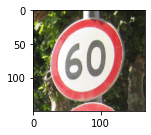

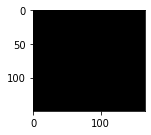

In [36]:
def blue_mask(hsv):
    lower_blue = np.array([80, 125, 40])
    upper_blue = np.array([140, 255, 255])
    mask = cv.inRange(hsv, lower_blue, upper_blue)
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

img = random_img()[1]
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
plot(blue_mask(hsv))

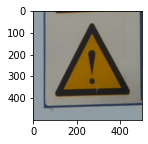

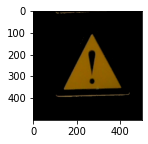

In [37]:
def yellow_mask(hsv):
    lower_yellow = np.array([10, 100, 50])
    upper_yellow = np.array([40, 255, 255])
    mask = cv.inRange(hsv, lower_yellow, upper_yellow)
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

img = random_img()[1]
img = cv.resize(img, (500, 500))
# img = rgb
# img = img4
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
plot(cv.bitwise_and(rgb_, rgb_, mask=yellow_mask(hsv)))

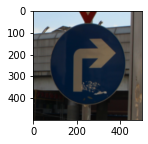

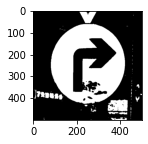

In [39]:
def hsv_color_range_threshold(hsv):
    mask = red_mask(hsv) + blue_mask(hsv) + yellow_mask(hsv)
    # mask = blue_mask(hsv) + (cv.bitwise_not(red_mask(hsv)))
    # mask = cv.bitwise_not(yellow_mask(hsv)) + ((mask))
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY)[1]

img = random_img()[1]
img = cv.resize(img, (500, 500))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plot(hsv_color_range_threshold(hsv))

## HSV Hue and Saturation Thresholding

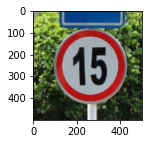

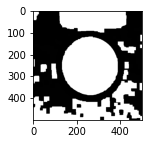

In [40]:
def hsv_threshold(hsv):
    h, s, v = cv.split(hsv)

    _, h_thresh = cv.threshold(h, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, s_thresh = cv.threshold(s, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, v_thresh = cv.threshold(v, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    thresh = cv.bitwise_and(h_thresh, s_thresh)
    thresh = (h_thresh - v_thresh) | cv.bitwise_not(s_thresh)
    thresh = cv.bitwise_not(thresh)
    thresh = cv.erode(thresh, np.ones((7, 7), np.uint8), iterations=1)
    # thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, np.ones((7, 7), np.uint8))
    thresh = cv.dilate(thresh, np.ones((12, 12), np.uint8), iterations=1)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    thresh = cv.bitwise_not(thresh)
    
    return thresh

img = random_img()[1]
img = cv.resize(img, (500, 500))
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
plot(hsv_threshold(hsv))

In [42]:
def get_threshs(hsv):
    threshs = []
    threshs.append(red_mask(hsv))
    threshs.append(blue_mask(hsv))
    threshs.append(yellow_mask(hsv))
    threshs.append(hsv_threshold(hsv))
    threshs.append(hsv_color_range_threshold(hsv))
    threshs.append(cv.add(red_mask(hsv), blue_mask(hsv)))
    
    
    for i in range(len(threshs)):
        # threshs[i] = cv.bitwise_not(threshs[i])
        h, w = threshs[i].shape[:2]
        thresh = threshs[i]
        # thresh = cv.erode(thresh, np.ones((5,5), np.uint8), iterations=1)
        # kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
        # thresh = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel)
        # thresh = cv.dilate(thresh, np.ones((3,3), np.uint8), iterations=1)
        # threshs[i] = cv.morphologyEx(threshs[i], cv.MORPH_CLOSE, np.ones((3,3), np.uint8))
        # mask = np.zeros((h+2, w+2), np.uint8)
        # # cv.floodFill(threshs[i], mask, (0,0), 255)
        
        # # Copy the thresholded image.
        # im_floodfill = threshs[i].copy()
        # # Mask used to flood filling.

        # # Notice the size needs to be 2 pixels than the image.
        # h, w = threshs[i].shape[:2]
        # mask = np.zeros((h+2, w+2), np.uint8)

        # # Floodfill from point (0, 0)
        # cv.floodFill(im_floodfill, mask, (0,0), 255)
            
        # # Invert floodfilled image
        # im_floodfill_inv = cv.bitwise_not(im_floodfill)
        
        # # Combine the two images to get the foreground.
        # threshs[i] = threshs[i] | im_floodfill_inv
        threshs[i] = thresh 
        # plot(threshs[i])
        
    return threshs

hsv = cv.cvtColor(random_img(477)[1], cv.COLOR_BGR2HSV)
hsv = cv.resize(hsv, (500, 500))
# get_threshs(hsv)

In [88]:
def get_bounding_box(thresh):
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return sorted(contours, key=cv.contourArea, reverse=True)

def get_contour(img, threshs):
    contours = []
    for i in threshs:
        for j in get_bounding_box(i):
            contours.append(j)
    height, width = img.shape[:2]
    
    cnts = []
    for c in contours:
        area = cv.contourArea(c)
        x, y, w, h = cv.boundingRect(c)
        ratio = w / h
        if ((w/h)<1.21 and (w/h)>0.59 and w>20):
            if h != height and w != width:
                cnts.append(c)
            
    largest_contour = max(cnts, key=cv.contourArea) if cnts else None
    if largest_contour is not None:
        x, y, w, h = cv.boundingRect(largest_contour)
    return [x, y, w, h]

# Display Image

In [82]:
def pred_box(img):
    img = cv.resize(img, (500, 500))
    
    rgb = cv.cvtColor(img.copy(), cv.COLOR_BGR2RGB)
    hsv = cv.cvtColor(img.copy(), cv.COLOR_BGR2HSV)
    
    # hsv = cv.medianBlur(hsv, 5)
    # hsv = cv.bilateralFilter(hsv, 9, 75, 75)
    
    threshs = get_threshs(hsv)
    
    x, y, w, h = get_contour(rgb, threshs)
    rgb = cv.rectangle(rgb, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return [x, y, w, h], rgb

def actual_box(idx):
    img = images[idx]
    height, width = img.shape[:2]
    x, y, w, h = data.iloc[idx]['x1'], data.iloc[idx]['y1'], data.iloc[idx]['x2'] - data.iloc[idx]['x1'], data.iloc[idx]['y2'] - data.iloc[idx]['y1']
    x, w = int(x * 500 / width), int(w * 500 / width)
    y, h = int(y * 500 / height), int(h * 500 / height)
    img = cv.resize(img, (500, 500))
    img = cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 4)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return [x, y, w, h], img

def test_box(filename):
    return actual_box(data[data['filename'] == filename].index[0])

In [45]:
# accuracy evaluation
# The measure works by calculating the overlapping areas of intersection between two bounding boxes, divided by the total area of both bounding boxes. This produces an “accuracy score” that can be used to measure how close two bounding boxes match.

def intersection_over_union(pred, actual):
    x1, y1, w1, h1 = pred
    x2, y2, w2, h2 = actual
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (w1 + 1) * (h1 + 1)
    boxBArea = (w2 + 1) * (h2 + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou * 100

# Test

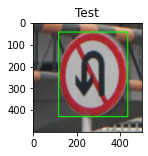

time:		11.3 ms
Accuracy:	91.88%


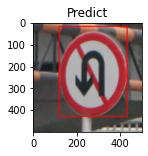

Area and ratio of predicted box: 128544 and 0.7572815533980582


In [117]:
idx, img = random_img()
filename = '015_1_0001.png'
img = cv.imread('test/' + filename)


# actualBox, actual = actual_box(idx)
# plot(actual, 'Actual')

testBox, test = test_box(filename)
plot(test, 'Test')

start = time.perf_counter()

predBox, pred = pred_box(img)

end = time.perf_counter()
iou = intersection_over_union(predBox, testBox)

print(f'time:\t\t{round((end - start) * 1000, 2)} ms')
print(f'Accuracy:\t{round(iou, 2)}%')

plot(pred, 'Predict')

print(f'Area and ratio of predicted box: {predBox[2] * predBox[3]} and {predBox[2] / predBox[3]}')


In [118]:
import time
def accuracy(data):
    acc = []
    time_ms = []
    for i in range(len(data)):
        start = time.perf_counter()
        pred = pred_box(images[i])[0]
        time_ms.append((time.perf_counter() - start)*1000)
        actual = actual_box(i)[0]
        iou = intersection_over_union(pred, actual)
        acc.append(iou)
        sys.stdout.write('\r')
        sys.stdout.write('Image {} accuracy: {:.2f}%\taverage accuracy: {:.2f}%\ttime taken: {:.2f}'.format(i, iou, np.mean(acc), np.mean(time_ms)))
        sys.stdout.write("\t[%-20s] %d%%" % ('█'*int(i/len(data)*20), 100*i/len(data)))
        sys.stdout.flush()
    print(f'\nAverage accuracy: {np.mean(acc)}%')
    print(f'Average time taken: {np.mean(time_ms)} ms')
    return acc, time_ms

accuracy, time_ms = accuracy(data)


Image 4169 accuracy: 96.15%	average accuracy: 85.79%	time taken: 12.74	[███████████████████ ] 99%
Average accuracy: 85.78588558289002%
Average time taken: 12.735284783931077 ms


Image 69 accuracy: 61.88%
Average accuracy: 79.0906726861843%


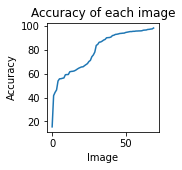

In [120]:
# load all filename of images in test folder
test_path = "test/"
filename = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

# get x1, y1, x2, y2 of each image
test_data = pd.DataFrame(columns=['filename', 'x1', 'y1', 'x2', 'y2'])
for i in range(len(filename)):
    img = cv.imread(test_path + filename[i])
    height, width = img.shape[:2]
    x, y, w, h = data.iloc[i]['x1'], data.iloc[i]['y1'], data.iloc[i]['x2'] - data.iloc[i]['x1'], data.iloc[i]['y2'] - data.iloc[i]['y1']
    x, w = int(x * 500 / width), int(w * 500 / width)
    y, h = int(y * 500 / height), int(h * 500 / height)
    test_data.loc[i] = [filename[i], x, y, x+w, y+h]

test_images = []
for i in range(len(test_data)):
    img = cv.imread(test_path + test_data.iloc[i]['filename'])
    test_images.append(img)
    

# get accuracy of each image
accuracy = []
for i in range(len(test_data)):
    pred, p = pred_box(test_images[i])
    test, t = test_box(test_data.iloc[i]['filename'])
    accuracy.append(intersection_over_union(pred, test))
    sys.stdout.write('\r')
    sys.stdout.write('Image {} accuracy: {:.2f}%'.format(i, accuracy[i]))
    sys.stdout.flush()
print(f'\nAverage accuracy: {np.mean(accuracy)}%')

# plot accuracy of each image
plt.plot(np.sort(accuracy))
plt.title('Accuracy of each image')
plt.xlabel('Image')
plt.ylabel('Accuracy')
plt.show()


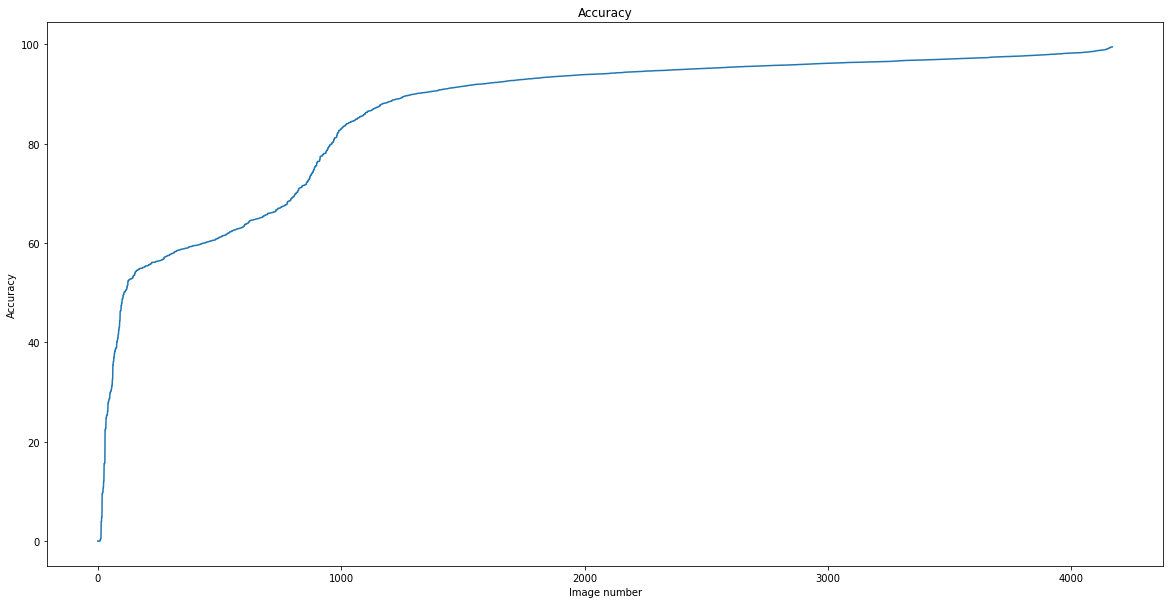


Average accuracy: 86.29%
Average time taken: 12.99 ms
Number of images with accuracy >= 95%: 1754
479 706 710 838 1495 2564 2791 2795 2923 3580 

In [19]:
acc = accuracy
acc = np.sort(acc)
plt.plot(acc)
# plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Accuracy')
plt.xlabel('Image number')
plt.ylabel('Accuracy')
plt.show()

# # accuracy vs time taken
# plt.plot(time_ms, acc)
# plt.rcParams['figure.figsize'] = [5, 2]
# plt.title('Accuracy vs Time taken')
# plt.xlabel('Time taken (ms)')
# plt.ylabel('Accuracy')
# plt.show()


# 2 decimal place
print(f'\nAverage accuracy: {round(np.mean(acc), 2)}%')
print(f'Average time taken: {round(np.mean(time_ms), 2)} ms')

# how many images have accuracy >= 70%
percent = 95 
print(f'Number of images with accuracy >= {percent}%: {len([i for i in accuracy if i >= percent])}')
for i in range(len(accuracy)):
    if accuracy[i] <= 0:
        print(i, end=' ')
        

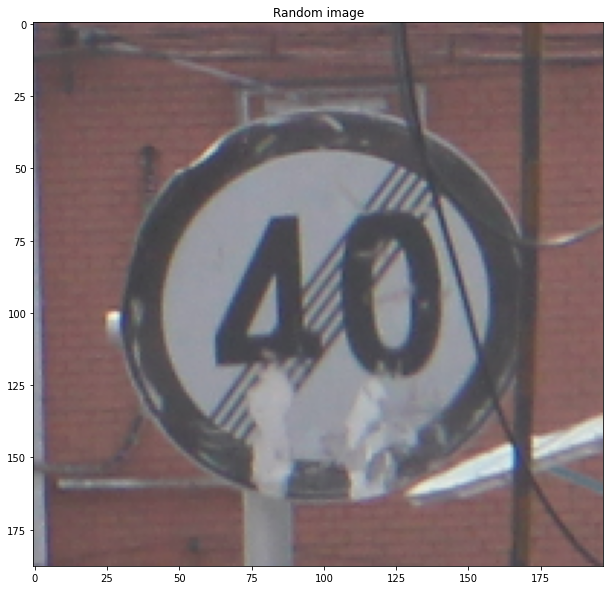

In [20]:
plot(cv.cvtColor(random_img(477)[1], cv.COLOR_BGR2RGB), 'Random image')

In [21]:
def accuracy_class(acc):
    class_acc = {'class': [], 'accuracy': []}
    for i in range(58):
        class_idx = data[data['class'] == i].index
        class_acc['class'].append(i)
        class_acc['accuracy'].append(np.mean([acc[j] for j in class_idx]))
    return class_acc

def plot_accuracy(acc, class_number):
    class_idx = data[data['class'] == class_number].index
    class_acc = [accuracy[i] for i in class_idx]
    class_acc = np.sort(class_acc)
    plt.plot(class_acc)
    plt.title(f'Class {class_number} accuracy')
    plt.xlabel('Image number')
    plt.ylabel('Accuracy')
    plt.show()



Top 10 classes with lowest accuracy:
Class 1 accuracy: 67.61001140215635
Class 2 accuracy: 69.48412778356314
Class 0 accuracy: 70.26702985172754
Class 9 accuracy: 76.62772373938309
Class 19 accuracy: 77.97353727054055
Class 25 accuracy: 78.67285788218862
Class 3 accuracy: 79.8388337974235
Class 8 accuracy: 80.0789436591819
Class 33 accuracy: 80.36912176780993
Class 5 accuracy: 81.17537650611618


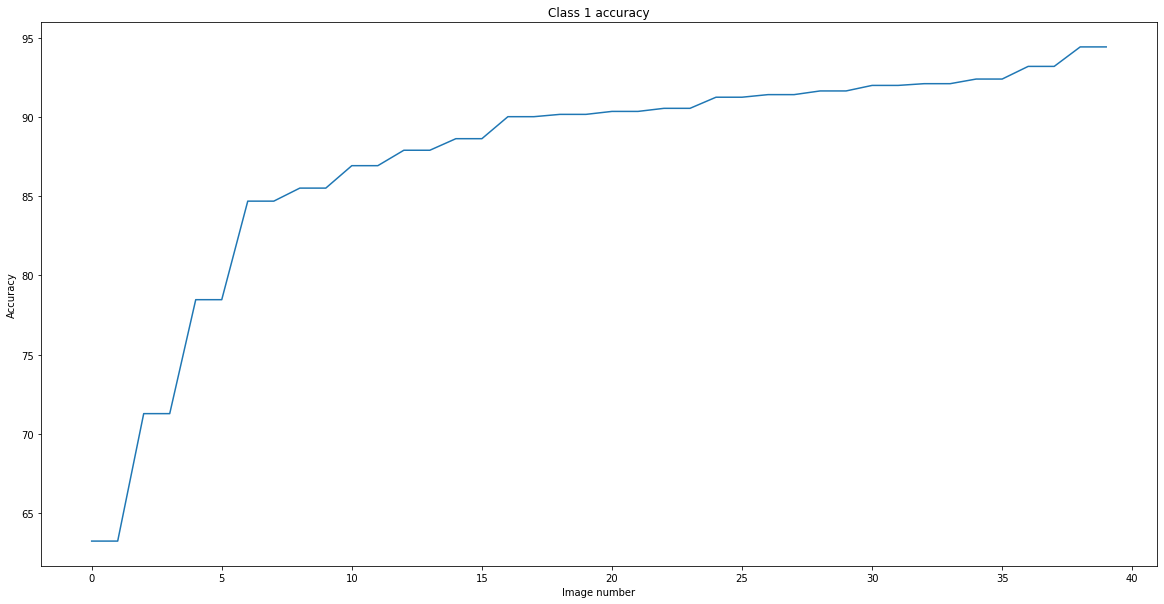

In [22]:
class_acc = accuracy_class(acc)
sort = np.argsort(class_acc['accuracy'])
    
print('\nTop 10 classes with lowest accuracy:')
for i in sort[:10]:
    print(f'Class {class_acc["class"][i]} accuracy: {class_acc["accuracy"][i]}')

plot_accuracy(accuracy, 1)

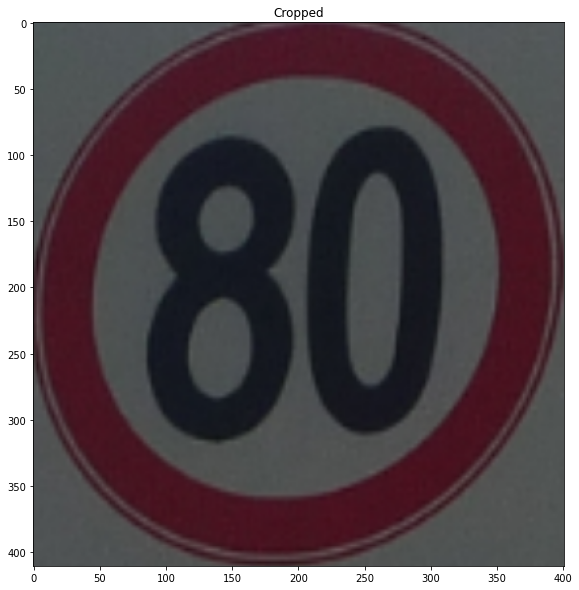

In [23]:
# Crop pred box
def crop_pred(idx):
    img = images[idx]
    pred = pred_box(img)[0]
    x, y, w, h = pred
    # resize to 500x500
    img = cv.resize(img, (500, 500))
    img = img[y:y+h, x:x+w]
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img
plot(crop_pred(random_img()[0]), 'Cropped')

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization

# create a CNN that output for 58 class
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(500, 500, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=1024, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=58, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
    

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-20 18:19:53.043880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-20 18:19:53.044223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 128)      0

In [25]:
# LeNet-5 CNN 
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(500, 500, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=58, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 496, 496, 6)       456       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 248, 248, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 244, 244, 16)      2416      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 122, 122, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 238144)            0         
                                                                 
 dense_1 (Dense)             (None, 120)              